In [1]:
# torch.cuda.empty_cache()

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import boto3
import io
import os

# new libraries
from models_package.models import Teacher, Student, CustomResNet18
from torchvision import datasets, transforms, models
from data.data_loader import load_cifar10, load_cifar100, load_imagenet, load_prof, load_wider
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from torchvision.models.resnet import ResNet18_Weights, ResNet34_Weights
from utils.loss_functions import tkd_kdloss, DD_loss, AD_loss, RKDDistanceLoss, RKDAngleLoss

In [18]:
def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    dataiter = iter(dataloader)
    data = next(dataiter)
    inputs = data['img']
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)
            
        teacher_preds = torch.argmax(teacher_outputs, dim=1).cpu().numpy()
        student_preds = torch.argmax(student_outputs, dim=1).cpu().numpy()
        
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(teacher_preds)
        all_student_preds.append(student_preds)

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return {
        'metrics': metrics,
        'all_labels': all_labels,
        'all_teacher_preds': all_teacher_preds,
        'all_student_preds': all_student_preds
    }
    
def plot_comparison(labels, teacher_values, student_values, title, ylabel):
    # Convert parameter count to millions
    if 'Parameter Count' in title or 'Parameter Count' in ylabel:
        teacher_values = [value / 1e6 for value in teacher_values]
        student_values = [value / 1e6 for value in student_values]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
    rects2 = ax.bar(x + width/2, student_values, width, label='Student')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()
    plt.show()

In [2]:
# Hyperparameters
learning_rate = 0.007143281748064771
num_epochs = 240
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 30
step_size = 30
gamma = 0.1
beta = 0.0
patience = 7  # for early stopping

batch_size = 16
num_workers = 2

# class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
# class_labels_new = torch.tensor([i for i in range(len(class_labels))])

In [3]:
# Load WIDER dataset

train_file = 'data/wider/trainval_wider.json'
test_file = 'data/wider/test_wider.json'

trainloader, testloader  = load_wider(train_file, test_file, batch_size, num_workers) 

Compose(
    RandAugment(num_ops=2, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [39]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = models.resnet50(pretrained=True)  # Keep ResNet50 as it is
teacher_model.eval()  # Set teacher model to evaluation mode
student_model = CustomResNet18()

In [40]:
# Ensure the final classification layer is added to the model
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, 100)
student_model.fc = nn.Linear(student_model.output_size, 100)

# Optimizer and scheduler for the student model
optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()

# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
# teacher_model.to(device)
# student_model.to(device)


In [41]:
torch.cuda.empty_cache()

In [29]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [30]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "0"


100%|████████████████████████████████████████████████████████████████████████████████████████████| 646/646 [01:36<00:00,  6.70it/s]


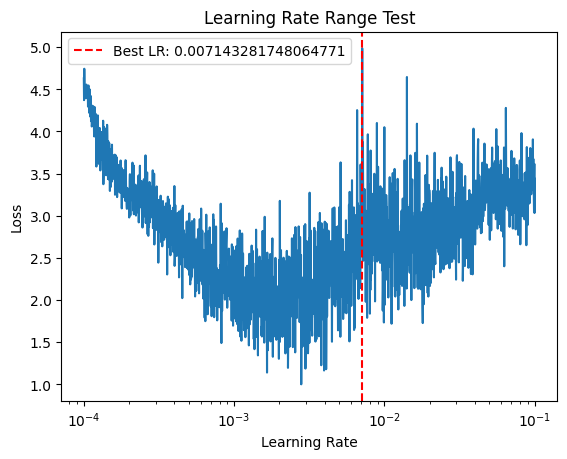

Best learning rate: 0.007143281748064771
0.007143281748064771


In [32]:
#### finding the optimal learning rate
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5, lr_range=(1e-4, 1e-1), plot_loss=True):
    model.train()
    model.to(device)
    lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), num_epochs * len(trainloader))  # Generate learning rates for each batch
    lr_iter = iter(lr_values)
    losses = []
    lrs = []
    
    for epoch in range(num_epochs):
        for i, batch in enumerate(tqdm(trainloader)):
            lr = next(lr_iter)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr  # Set new learning rate
            
            inputs, labels = batch['img'].to(device), batch['label'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            lrs.append(lr)
    
    # Calculate the derivative of the loss
    loss_derivative = np.gradient(losses)
    
    # Find the learning rate corresponding to the minimum derivative (steepest decline)
    best_lr_index = np.argmin(loss_derivative)
    best_lr = lrs[best_lr_index]
    
    if plot_loss:
        import matplotlib.pyplot as plt
        plt.figure()
        plt.plot(lrs, losses)
        plt.xscale('log')
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.title('Learning Rate Range Test')
        plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
        plt.legend()
        plt.show()
    
    print(f'Best learning rate: {best_lr}')
    return best_lr

############# input ############## 
best_lr = train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=3)  
print(best_lr)

In [53]:
# Function to train the teacher model
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5, patience=5):
    model.train()
    model.to(device)
    best_train_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        for i, batch in enumerate(tqdm(trainloader)):            
            inputs, labels = batch['img'].to(device), batch['label'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        epoch_loss /= num_batches  
        
        # Check for early stopping
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            patience_counter = 0 
            # checkpoint
            torch.save(model.state_dict(), f'teacher_model_weights_rkd_prof_checkpoint.pth')
            torch.save(model, f'teacher_model_rkd_prof_checkpoint.pth')

        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping')
            break

        scheduler.step()

    print("Finished Training Teacher")


# Function to train the student model with knowledge distillation
def train_student_with_distillation(student, teacher, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs, patience=5):
    student.train()
    teacher.eval()
    student.to(device)
    teacher.to(device)
    best_train_loss = float('inf')  
    patience_counter = 0 

    for epoch in range(num_epochs):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        for i, batch in enumerate(tqdm(trainloader)):
            inputs, labels = batch['img'].to(device), batch['label'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)
            # ce_loss = criterion(student_outputs, labels)
            # kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # from utils.loss_functions
            # loss = alpha * kd_loss + (1 - alpha) * ce_loss

            distance_loss = RKDDistanceLoss()(student_outputs, teacher_outputs)
            angle_loss = RKDAngleLoss()(student_outputs, teacher_outputs)
            loss = criterion(student_outputs, labels) + 0.1 * (distance_loss + angle_loss)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            if i % 100 == 99:  
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        epoch_loss /= num_batches  

        # Check for early stopping
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            patience_counter = 0 
            torch.save(student.state_dict(), f'student_model_weights_rkd_prof_checkpoint.pth')
            torch.save(student, f'student_model_rkd_prof_checkpoint.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        scheduler.step() 

    print("Finished Training Student")

In [54]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [55]:
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Call the function to train the teacher model
train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=num_epochs)

# Call the function to train the student model with knowledge distillation
train_student_with_distillation(student_model, teacher_model, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs=num_epochs)


 15%|██████████████▏                                                                             | 100/646 [00:15<01:21,  6.72it/s]

[1, 100] loss: 3.080


 31%|████████████████████████████▍                                                               | 200/646 [00:30<01:08,  6.51it/s]

[1, 200] loss: 3.148


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:45<00:53,  6.45it/s]

[1, 300] loss: 2.743


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:59<00:38,  6.46it/s]

[1, 400] loss: 2.499


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:23,  6.25it/s]

[1, 500] loss: 2.431


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:29<00:06,  7.28it/s]

[1, 600] loss: 2.354


 15%|██████████████▎                                                                              | 99/646 [00:14<01:18,  6.93it/s]

[2, 100] loss: 2.193


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:08,  6.55it/s]

[2, 200] loss: 2.115


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:43<00:46,  7.43it/s]

[2, 300] loss: 2.168


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:37,  6.56it/s]

[2, 400] loss: 2.086


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:13<00:21,  6.78it/s]

[2, 500] loss: 2.099


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:28<00:06,  6.79it/s]

[2, 600] loss: 2.027


 15%|██████████████▎                                                                              | 99/646 [00:15<01:27,  6.27it/s]

[3, 100] loss: 1.810


 31%|████████████████████████████▍                                                               | 200/646 [00:29<00:57,  7.75it/s]

[3, 200] loss: 1.954


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:59,  5.82it/s]

[3, 300] loss: 1.946


 62%|█████████████████████████████████████████████████████████                                   | 401/646 [00:59<00:32,  7.55it/s]

[3, 400] loss: 1.878


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:25,  5.82it/s]

[3, 500] loss: 1.851


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:28<00:06,  7.34it/s]

[3, 600] loss: 1.807


 15%|██████████████▎                                                                              | 99/646 [00:15<01:24,  6.50it/s]

[4, 100] loss: 1.617


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:06,  6.68it/s]

[4, 200] loss: 1.674


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:51,  6.75it/s]

[4, 300] loss: 1.743


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:34,  7.15it/s]

[4, 400] loss: 1.638


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:21,  6.81it/s]

[4, 500] loss: 1.742


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:28<00:07,  6.52it/s]

[4, 600] loss: 1.739


 15%|██████████████▎                                                                              | 99/646 [00:15<01:18,  6.95it/s]

[5, 100] loss: 1.476


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:13,  6.11it/s]

[5, 200] loss: 1.535


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:51,  6.72it/s]

[5, 300] loss: 1.506


 62%|█████████████████████████████████████████████████████████                                   | 401/646 [00:59<00:33,  7.23it/s]

[5, 400] loss: 1.526


 78%|███████████████████████████████████████████████████████████████████████▎                    | 501/646 [01:14<00:19,  7.46it/s]

[5, 500] loss: 1.606


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:28<00:06,  6.75it/s]

[5, 600] loss: 1.610


 16%|██████████████▍                                                                             | 101/646 [00:15<01:23,  6.55it/s]

[6, 100] loss: 1.347


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:02,  7.15it/s]

[6, 200] loss: 1.361


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:50,  6.91it/s]

[6, 300] loss: 1.481


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:39,  6.28it/s]

[6, 400] loss: 1.509


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:20,  7.11it/s]

[6, 500] loss: 1.471


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:29<00:07,  5.94it/s]

[6, 600] loss: 1.452


 15%|██████████████▏                                                                             | 100/646 [00:14<01:24,  6.43it/s]

[7, 100] loss: 1.235


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:08,  6.52it/s]

[7, 200] loss: 1.308


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:43<00:49,  6.97it/s]

[7, 300] loss: 1.343


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:40,  6.09it/s]

[7, 400] loss: 1.348


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:23,  6.24it/s]

[7, 500] loss: 1.338


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:29<00:07,  6.25it/s]

[7, 600] loss: 1.443


 15%|██████████████▎                                                                              | 99/646 [00:14<01:22,  6.65it/s]

[8, 100] loss: 1.156


 31%|████████████████████████████▋                                                               | 201/646 [00:29<01:05,  6.81it/s]

[8, 200] loss: 1.274


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:50,  6.82it/s]

[8, 300] loss: 1.236


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:39,  6.25it/s]

[8, 400] loss: 1.308


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:13<00:22,  6.42it/s]

[8, 500] loss: 1.309


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:28<00:06,  6.94it/s]

[8, 600] loss: 1.337


 15%|██████████████▏                                                                             | 100/646 [00:15<01:17,  7.06it/s]

[9, 100] loss: 1.027


 31%|████████████████████████████▍                                                               | 200/646 [00:30<01:10,  6.33it/s]

[9, 200] loss: 1.133


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:53,  6.51it/s]

[9, 300] loss: 1.114


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:59<00:34,  7.22it/s]

[9, 400] loss: 1.119


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:20,  7.02it/s]

[9, 500] loss: 1.193


 93%|█████████████████████████████████████████████████████████████████████████████████████▌      | 601/646 [01:29<00:06,  6.84it/s]

[9, 600] loss: 1.235


 15%|██████████████▏                                                                             | 100/646 [00:14<01:23,  6.57it/s]

[10, 100] loss: 1.001


 31%|████████████████████████████▋                                                               | 201/646 [00:29<01:03,  7.05it/s]

[10, 200] loss: 1.023


 47%|██████████████████████████████████████████▊                                                 | 301/646 [00:43<00:52,  6.55it/s]

[10, 300] loss: 1.106


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:57<00:33,  7.46it/s]

[10, 400] loss: 1.103


 78%|███████████████████████████████████████████████████████████████████████▎                    | 501/646 [01:12<00:19,  7.30it/s]

[10, 500] loss: 1.168


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:27<00:06,  6.88it/s]

[10, 600] loss: 1.150


 15%|██████████████▎                                                                              | 99/646 [00:14<01:16,  7.11it/s]

[11, 100] loss: 0.847


 31%|████████████████████████████▋                                                               | 201/646 [00:29<01:01,  7.27it/s]

[11, 200] loss: 0.994


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:43<00:57,  6.07it/s]

[11, 300] loss: 0.994


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:58<00:34,  7.12it/s]

[11, 400] loss: 1.024


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:21,  6.75it/s]

[11, 500] loss: 1.057


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:28<00:06,  7.65it/s]

[11, 600] loss: 1.077


 15%|██████████████▏                                                                             | 100/646 [00:14<01:24,  6.45it/s]

[12, 100] loss: 0.844


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:05,  6.77it/s]

[12, 200] loss: 0.910


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:49,  6.92it/s]

[12, 300] loss: 0.883


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:37,  6.61it/s]

[12, 400] loss: 0.987


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:22,  6.56it/s]

[12, 500] loss: 0.972


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:29<00:06,  7.35it/s]

[12, 600] loss: 0.976


 16%|██████████████▍                                                                             | 101/646 [00:14<01:14,  7.29it/s]

[13, 100] loss: 0.759


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:06,  6.67it/s]

[13, 200] loss: 0.803


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:53,  6.51it/s]

[13, 300] loss: 0.885


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:33,  7.34it/s]

[13, 400] loss: 0.808


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:21,  6.91it/s]

[13, 500] loss: 0.889


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:29<00:06,  7.04it/s]

[13, 600] loss: 0.907


 15%|██████████████▏                                                                             | 100/646 [00:15<01:20,  6.79it/s]

[14, 100] loss: 0.723


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:07,  6.60it/s]

[14, 200] loss: 0.768


 47%|██████████████████████████████████████████▊                                                 | 301/646 [00:44<00:47,  7.30it/s]

[14, 300] loss: 0.780


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:58<00:35,  6.91it/s]

[14, 400] loss: 0.879


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:13<00:22,  6.43it/s]

[14, 500] loss: 0.820


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:28<00:06,  6.81it/s]

[14, 600] loss: 0.802


 15%|██████████████▎                                                                              | 99/646 [00:14<01:15,  7.26it/s]

[15, 100] loss: 0.570


 31%|████████████████████████████▋                                                               | 201/646 [00:29<01:02,  7.13it/s]

[15, 200] loss: 0.643


 47%|██████████████████████████████████████████▊                                                 | 301/646 [00:44<00:49,  6.96it/s]

[15, 300] loss: 0.724


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:36,  6.77it/s]

[15, 400] loss: 0.717


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:14<00:23,  6.36it/s]

[15, 500] loss: 0.746


 93%|█████████████████████████████████████████████████████████████████████████████████████▌      | 601/646 [01:29<00:05,  7.51it/s]

[15, 600] loss: 0.837


 15%|██████████████▏                                                                             | 100/646 [00:14<01:17,  7.05it/s]

[16, 100] loss: 0.557


 31%|████████████████████████████▋                                                               | 201/646 [00:29<01:01,  7.20it/s]

[16, 200] loss: 0.698


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:43<00:52,  6.64it/s]

[16, 300] loss: 0.611


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:58<00:36,  6.73it/s]

[16, 400] loss: 0.709


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:13<00:22,  6.59it/s]

[16, 500] loss: 0.666


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:28<00:07,  6.17it/s]

[16, 600] loss: 0.734


 15%|██████████████▏                                                                             | 100/646 [00:15<01:26,  6.31it/s]

[17, 100] loss: 0.574


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:00,  7.41it/s]

[17, 200] loss: 0.557


 47%|██████████████████████████████████████████▊                                                 | 301/646 [00:45<00:50,  6.78it/s]

[17, 300] loss: 0.596


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:35,  6.92it/s]

[17, 400] loss: 0.627


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:14<00:21,  6.94it/s]

[17, 500] loss: 0.696


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:29<00:06,  6.64it/s]

[17, 600] loss: 0.623


 15%|██████████████▏                                                                             | 100/646 [00:15<01:21,  6.70it/s]

[18, 100] loss: 0.520


 31%|████████████████████████████▍                                                               | 200/646 [00:30<01:07,  6.60it/s]

[18, 200] loss: 0.583


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:45<00:50,  6.79it/s]

[18, 300] loss: 0.586


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [01:00<00:38,  6.46it/s]

[18, 400] loss: 0.535


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:15<00:21,  6.72it/s]

[18, 500] loss: 0.657


 93%|█████████████████████████████████████████████████████████████████████████████████████▌      | 601/646 [01:29<00:06,  7.06it/s]

[18, 600] loss: 0.616


 15%|██████████████▎                                                                              | 99/646 [00:14<01:25,  6.43it/s]

[19, 100] loss: 0.471


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:00,  7.36it/s]

[19, 200] loss: 0.506


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:43<00:49,  6.94it/s]

[19, 300] loss: 0.558


 62%|█████████████████████████████████████████████████████████                                   | 401/646 [00:58<00:34,  7.10it/s]

[19, 400] loss: 0.527


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:12<00:24,  5.89it/s]

[19, 500] loss: 0.598


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:27<00:07,  5.93it/s]

[19, 600] loss: 0.573


 16%|██████████████▍                                                                             | 101/646 [00:15<01:14,  7.35it/s]

[20, 100] loss: 0.423


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:09,  6.45it/s]

[20, 200] loss: 0.437


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:56,  6.17it/s]

[20, 300] loss: 0.472


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:40,  6.14it/s]

[20, 400] loss: 0.452


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:22,  6.56it/s]

[20, 500] loss: 0.529


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:29<00:06,  6.92it/s]

[20, 600] loss: 0.548


 15%|██████████████▎                                                                              | 99/646 [00:15<01:25,  6.38it/s]

[21, 100] loss: 0.417


 31%|████████████████████████████▎                                                               | 199/646 [00:30<01:06,  6.71it/s]

[21, 200] loss: 0.442


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:45<00:54,  6.38it/s]

[21, 300] loss: 0.443


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [01:00<00:40,  6.12it/s]

[21, 400] loss: 0.517


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:15<00:22,  6.63it/s]

[21, 500] loss: 0.470


 93%|█████████████████████████████████████████████████████████████████████████████████████▌      | 601/646 [01:30<00:06,  6.99it/s]

[21, 600] loss: 0.493


 15%|██████████████▎                                                                              | 99/646 [00:14<01:25,  6.38it/s]

[22, 100] loss: 0.429


 31%|████████████████████████████▋                                                               | 201/646 [00:30<01:01,  7.29it/s]

[22, 200] loss: 0.399


 47%|██████████████████████████████████████████▊                                                 | 301/646 [00:44<00:46,  7.43it/s]

[22, 300] loss: 0.446


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:59<00:37,  6.58it/s]

[22, 400] loss: 0.481


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:20,  7.19it/s]

[22, 500] loss: 0.436


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:29<00:07,  6.52it/s]

[22, 600] loss: 0.514


 15%|██████████████▎                                                                              | 99/646 [00:15<01:24,  6.49it/s]

[23, 100] loss: 0.394


 31%|████████████████████████████▋                                                               | 201/646 [00:30<01:05,  6.84it/s]

[23, 200] loss: 0.353


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:45<00:46,  7.45it/s]

[23, 300] loss: 0.362


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [01:00<00:36,  6.82it/s]

[23, 400] loss: 0.396


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:15<00:22,  6.52it/s]

[23, 500] loss: 0.466


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:29<00:07,  6.14it/s]

[23, 600] loss: 0.392


 15%|██████████████▏                                                                             | 100/646 [00:15<01:35,  5.74it/s]

[24, 100] loss: 0.392


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:02,  7.13it/s]

[24, 200] loss: 0.366


 47%|██████████████████████████████████████████▊                                                 | 301/646 [00:44<00:52,  6.56it/s]

[24, 300] loss: 0.346


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:35,  6.91it/s]

[24, 400] loss: 0.430


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:21,  6.82it/s]

[24, 500] loss: 0.471


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:29<00:07,  6.40it/s]

[24, 600] loss: 0.397


 15%|██████████████▎                                                                              | 99/646 [00:14<01:19,  6.84it/s]

[25, 100] loss: 0.302


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:03,  6.99it/s]

[25, 200] loss: 0.334


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:53,  6.50it/s]

[25, 300] loss: 0.369


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:58<00:37,  6.60it/s]

[25, 400] loss: 0.357


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:13<00:20,  7.02it/s]

[25, 500] loss: 0.386


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:28<00:07,  6.29it/s]

[25, 600] loss: 0.429


 15%|██████████████▏                                                                             | 100/646 [00:14<01:21,  6.68it/s]

[26, 100] loss: 0.291


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:13,  6.05it/s]

[26, 200] loss: 0.303


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:43<00:49,  6.92it/s]

[26, 300] loss: 0.346


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:58<00:37,  6.51it/s]

[26, 400] loss: 0.365


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:13<00:21,  6.98it/s]

[26, 500] loss: 0.328


 93%|█████████████████████████████████████████████████████████████████████████████████████▌      | 601/646 [01:27<00:06,  6.78it/s]

[26, 600] loss: 0.366


 15%|██████████████▎                                                                              | 99/646 [00:14<01:28,  6.16it/s]

[27, 100] loss: 0.265


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:09,  6.47it/s]

[27, 200] loss: 0.265


 47%|██████████████████████████████████████████▊                                                 | 301/646 [00:44<00:45,  7.51it/s]

[27, 300] loss: 0.364


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:36,  6.76it/s]

[27, 400] loss: 0.365


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:19,  7.38it/s]

[27, 500] loss: 0.335


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:29<00:06,  6.85it/s]

[27, 600] loss: 0.361


 15%|██████████████▏                                                                             | 100/646 [00:15<01:18,  6.94it/s]

[28, 100] loss: 0.315


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:03,  6.99it/s]

[28, 200] loss: 0.301


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<01:00,  5.70it/s]

[28, 300] loss: 0.306


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:36,  6.81it/s]

[28, 400] loss: 0.323


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:19,  7.65it/s]

[28, 500] loss: 0.293


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:28<00:06,  7.19it/s]

[28, 600] loss: 0.313


 15%|██████████████▏                                                                             | 100/646 [00:15<01:19,  6.90it/s]

[29, 100] loss: 0.289


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:07,  6.57it/s]

[29, 200] loss: 0.278


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:52,  6.56it/s]

[29, 300] loss: 0.285


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:59<00:39,  6.20it/s]

[29, 400] loss: 0.308


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:14<00:23,  6.39it/s]

[29, 500] loss: 0.303


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:29<00:07,  6.20it/s]

[29, 600] loss: 0.322


 16%|██████████████▍                                                                             | 101/646 [00:15<01:17,  7.03it/s]

[30, 100] loss: 0.239


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:04,  6.89it/s]

[30, 200] loss: 0.286


 47%|██████████████████████████████████████████▊                                                 | 301/646 [00:44<00:48,  7.09it/s]

[30, 300] loss: 0.252


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:59<00:39,  6.33it/s]

[30, 400] loss: 0.286


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:21,  6.64it/s]

[30, 500] loss: 0.297


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:29<00:06,  6.91it/s]

[30, 600] loss: 0.269


 15%|██████████████▏                                                                             | 100/646 [00:15<01:37,  5.62it/s]

[31, 100] loss: 0.192


 31%|████████████████████████████▍                                                               | 200/646 [00:30<01:03,  6.99it/s]

[31, 200] loss: 0.145


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:53,  6.50it/s]

[31, 300] loss: 0.156


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:33,  7.28it/s]

[31, 400] loss: 0.158


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:14<00:21,  6.91it/s]

[31, 500] loss: 0.119


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:28<00:06,  6.98it/s]

[31, 600] loss: 0.124


 15%|██████████████▏                                                                             | 100/646 [00:14<01:19,  6.89it/s]

[32, 100] loss: 0.101


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:03,  7.04it/s]

[32, 200] loss: 0.104


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:47,  7.27it/s]

[32, 300] loss: 0.103


 62%|█████████████████████████████████████████████████████████                                   | 401/646 [00:59<00:34,  7.01it/s]

[32, 400] loss: 0.093


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:13<00:20,  7.04it/s]

[32, 500] loss: 0.106


 93%|█████████████████████████████████████████████████████████████████████████████████████▌      | 601/646 [01:28<00:06,  6.52it/s]

[32, 600] loss: 0.095


 15%|██████████████▏                                                                             | 100/646 [00:15<01:19,  6.88it/s]

[33, 100] loss: 0.081


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:01,  7.23it/s]

[33, 200] loss: 0.070


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:49,  6.96it/s]

[33, 300] loss: 0.094


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:39,  6.26it/s]

[33, 400] loss: 0.073


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:13<00:20,  7.00it/s]

[33, 500] loss: 0.085


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:28<00:07,  6.24it/s]

[33, 600] loss: 0.076


 15%|██████████████▎                                                                              | 99/646 [00:14<01:21,  6.74it/s]

[34, 100] loss: 0.068


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:08,  6.54it/s]

[34, 200] loss: 0.065


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:51,  6.77it/s]

[34, 300] loss: 0.071


 62%|█████████████████████████████████████████████████████████                                   | 401/646 [00:59<00:36,  6.69it/s]

[34, 400] loss: 0.071


 78%|███████████████████████████████████████████████████████████████████████▎                    | 501/646 [01:13<00:21,  6.83it/s]

[34, 500] loss: 0.063


 93%|█████████████████████████████████████████████████████████████████████████████████████▌      | 601/646 [01:28<00:05,  7.59it/s]

[34, 600] loss: 0.073


 15%|██████████████▏                                                                             | 100/646 [00:14<01:20,  6.81it/s]

[35, 100] loss: 0.071


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:08,  6.52it/s]

[35, 200] loss: 0.075


 47%|██████████████████████████████████████████▊                                                 | 301/646 [00:44<00:48,  7.18it/s]

[35, 300] loss: 0.069


 62%|█████████████████████████████████████████████████████████                                   | 401/646 [00:58<00:37,  6.55it/s]

[35, 400] loss: 0.063


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:24,  5.99it/s]

[35, 500] loss: 0.058


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:28<00:06,  6.65it/s]

[35, 600] loss: 0.063


 16%|██████████████▍                                                                             | 101/646 [00:15<01:23,  6.56it/s]

[36, 100] loss: 0.070


 31%|████████████████████████████▎                                                               | 199/646 [00:30<01:03,  7.05it/s]

[36, 200] loss: 0.062


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:45<00:49,  6.96it/s]

[36, 300] loss: 0.042


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [01:00<00:34,  7.09it/s]

[36, 400] loss: 0.067


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:15<00:23,  6.30it/s]

[36, 500] loss: 0.057


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:29<00:06,  6.73it/s]

[36, 600] loss: 0.062


 16%|██████████████▍                                                                             | 101/646 [00:15<01:17,  7.07it/s]

[37, 100] loss: 0.059


 31%|████████████████████████████▋                                                               | 201/646 [00:30<01:00,  7.35it/s]

[37, 200] loss: 0.064


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:52,  6.54it/s]

[37, 300] loss: 0.070


 62%|█████████████████████████████████████████████████████████                                   | 401/646 [00:59<00:32,  7.56it/s]

[37, 400] loss: 0.087


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:13<00:20,  7.23it/s]

[37, 500] loss: 0.056


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:28<00:07,  6.46it/s]

[37, 600] loss: 0.052


 15%|██████████████▏                                                                             | 100/646 [00:15<01:15,  7.27it/s]

[38, 100] loss: 0.052


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:02,  7.09it/s]

[38, 200] loss: 0.045


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:49,  6.97it/s]

[38, 300] loss: 0.039


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:58<00:34,  7.15it/s]

[38, 400] loss: 0.059


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:13<00:19,  7.66it/s]

[38, 500] loss: 0.046


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:28<00:06,  7.20it/s]

[38, 600] loss: 0.065


 16%|██████████████▍                                                                             | 101/646 [00:15<01:19,  6.89it/s]

[39, 100] loss: 0.044


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:04,  6.96it/s]

[39, 200] loss: 0.060


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:51,  6.80it/s]

[39, 300] loss: 0.049


 62%|█████████████████████████████████████████████████████████                                   | 401/646 [00:58<00:34,  7.07it/s]

[39, 400] loss: 0.052


 78%|███████████████████████████████████████████████████████████████████████▎                    | 501/646 [01:13<00:20,  7.15it/s]

[39, 500] loss: 0.040


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:28<00:06,  6.91it/s]

[39, 600] loss: 0.056


 15%|██████████████▎                                                                              | 99/646 [00:14<01:21,  6.68it/s]

[40, 100] loss: 0.067


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:06,  6.73it/s]

[40, 200] loss: 0.034


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:46,  7.46it/s]

[40, 300] loss: 0.050


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:59<00:35,  6.87it/s]

[40, 400] loss: 0.058


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:21,  6.89it/s]

[40, 500] loss: 0.057


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:28<00:07,  6.65it/s]

[40, 600] loss: 0.044


 15%|██████████████▏                                                                             | 100/646 [00:14<01:15,  7.22it/s]

[41, 100] loss: 0.056


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:03,  7.01it/s]

[41, 200] loss: 0.051


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:50,  6.85it/s]

[41, 300] loss: 0.054


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:58<00:38,  6.46it/s]

[41, 400] loss: 0.053


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:14<00:23,  6.28it/s]

[41, 500] loss: 0.055


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:28<00:06,  6.85it/s]

[41, 600] loss: 0.042


 15%|██████████████▎                                                                              | 99/646 [00:14<01:15,  7.26it/s]

[42, 100] loss: 0.043


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:09,  6.43it/s]

[42, 200] loss: 0.034


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:52,  6.57it/s]

[42, 300] loss: 0.040


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:58<00:36,  6.79it/s]

[42, 400] loss: 0.039


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:13<00:22,  6.41it/s]

[42, 500] loss: 0.066


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:28<00:07,  6.65it/s]

[42, 600] loss: 0.041


 16%|██████████████▍                                                                             | 101/646 [00:15<01:11,  7.63it/s]

[43, 100] loss: 0.037


 31%|████████████████████████████▋                                                               | 201/646 [00:30<01:07,  6.59it/s]

[43, 200] loss: 0.041


 47%|██████████████████████████████████████████▊                                                 | 301/646 [00:44<00:51,  6.65it/s]

[43, 300] loss: 0.038


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:40,  6.06it/s]

[43, 400] loss: 0.051


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:14<00:21,  6.84it/s]

[43, 500] loss: 0.042


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:29<00:07,  6.08it/s]

[43, 600] loss: 0.038


 15%|██████████████▎                                                                              | 99/646 [00:15<01:16,  7.14it/s]

[44, 100] loss: 0.035


 31%|████████████████████████████▍                                                               | 200/646 [00:30<01:05,  6.81it/s]

[44, 200] loss: 0.045


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:55,  6.22it/s]

[44, 300] loss: 0.024


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:59<00:36,  6.78it/s]

[44, 400] loss: 0.030


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:13<00:19,  7.43it/s]

[44, 500] loss: 0.039


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:28<00:07,  6.41it/s]

[44, 600] loss: 0.054


 15%|██████████████▎                                                                              | 99/646 [00:14<01:28,  6.16it/s]

[45, 100] loss: 0.046


 31%|████████████████████████████▎                                                               | 199/646 [00:30<01:09,  6.43it/s]

[45, 200] loss: 0.050


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:45<00:48,  7.13it/s]

[45, 300] loss: 0.034


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [01:00<00:37,  6.48it/s]

[45, 400] loss: 0.029


 78%|███████████████████████████████████████████████████████████████████████▎                    | 501/646 [01:15<00:19,  7.27it/s]

[45, 500] loss: 0.040


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:30<00:07,  6.43it/s]

[45, 600] loss: 0.039


 15%|██████████████▎                                                                              | 99/646 [00:15<01:26,  6.31it/s]

[46, 100] loss: 0.038


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:04,  6.95it/s]

[46, 200] loss: 0.051


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:50,  6.91it/s]

[46, 300] loss: 0.033


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:58<00:37,  6.50it/s]

[46, 400] loss: 0.031


 78%|███████████████████████████████████████████████████████████████████████▎                    | 501/646 [01:14<00:20,  7.23it/s]

[46, 500] loss: 0.041


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:28<00:07,  6.60it/s]

[46, 600] loss: 0.028


 15%|██████████████▏                                                                             | 100/646 [00:14<01:18,  6.99it/s]

[47, 100] loss: 0.035


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:14,  6.00it/s]

[47, 200] loss: 0.036


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:49,  7.01it/s]

[47, 300] loss: 0.027


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:37,  6.55it/s]

[47, 400] loss: 0.031


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:21,  6.66it/s]

[47, 500] loss: 0.038


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:28<00:07,  6.25it/s]

[47, 600] loss: 0.045


 15%|██████████████▏                                                                             | 100/646 [00:15<01:43,  5.29it/s]

[48, 100] loss: 0.040


 31%|████████████████████████████▍                                                               | 200/646 [00:30<01:11,  6.24it/s]

[48, 200] loss: 0.033


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:49,  6.95it/s]

[48, 300] loss: 0.032


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:37,  6.55it/s]

[48, 400] loss: 0.045


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:14<00:24,  5.90it/s]

[48, 500] loss: 0.034


 93%|█████████████████████████████████████████████████████████████████████████████████████▌      | 601/646 [01:29<00:06,  7.29it/s]

[48, 600] loss: 0.027


 15%|██████████████▎                                                                              | 99/646 [00:14<01:15,  7.26it/s]

[49, 100] loss: 0.028


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:11,  6.26it/s]

[49, 200] loss: 0.030


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:48,  7.19it/s]

[49, 300] loss: 0.023


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:58<00:37,  6.50it/s]

[49, 400] loss: 0.022


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:13<00:19,  7.49it/s]

[49, 500] loss: 0.031


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:27<00:06,  6.85it/s]

[49, 600] loss: 0.040


 15%|██████████████▎                                                                              | 99/646 [00:15<01:28,  6.17it/s]

[50, 100] loss: 0.036


 31%|████████████████████████████▍                                                               | 200/646 [00:30<01:04,  6.90it/s]

[50, 200] loss: 0.019


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:56,  6.11it/s]

[50, 300] loss: 0.036


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [01:00<00:41,  5.97it/s]

[50, 400] loss: 0.034


 78%|███████████████████████████████████████████████████████████████████████▎                    | 501/646 [01:14<00:19,  7.41it/s]

[50, 500] loss: 0.039


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:29<00:06,  6.89it/s]

[50, 600] loss: 0.024


 15%|██████████████▏                                                                             | 100/646 [00:15<01:24,  6.49it/s]

[51, 100] loss: 0.041


 31%|████████████████████████████▍                                                               | 200/646 [00:30<01:03,  7.00it/s]

[51, 200] loss: 0.050


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:45<00:51,  6.73it/s]

[51, 300] loss: 0.020


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [01:00<00:37,  6.50it/s]

[51, 400] loss: 0.020


 78%|███████████████████████████████████████████████████████████████████████▎                    | 501/646 [01:15<00:20,  7.04it/s]

[51, 500] loss: 0.042


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:29<00:07,  6.67it/s]

[51, 600] loss: 0.033


 15%|██████████████▎                                                                              | 99/646 [00:14<01:12,  7.50it/s]

[52, 100] loss: 0.035


 31%|████████████████████████████▋                                                               | 201/646 [00:30<01:06,  6.70it/s]

[52, 200] loss: 0.023


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:54,  6.33it/s]

[52, 300] loss: 0.026


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:59<00:38,  6.47it/s]

[52, 400] loss: 0.029


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:15<00:21,  6.74it/s]

[52, 500] loss: 0.036


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:29<00:07,  6.56it/s]

[52, 600] loss: 0.028


 15%|██████████████▏                                                                             | 100/646 [00:14<01:16,  7.14it/s]

[53, 100] loss: 0.041


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:02,  7.08it/s]

[53, 200] loss: 0.023


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:56,  6.16it/s]

[53, 300] loss: 0.036


 62%|█████████████████████████████████████████████████████████                                   | 401/646 [00:59<00:34,  7.20it/s]

[53, 400] loss: 0.028


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:13<00:22,  6.59it/s]

[53, 500] loss: 0.037


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:28<00:06,  6.77it/s]

[53, 600] loss: 0.030


 15%|██████████████▎                                                                              | 99/646 [00:15<01:22,  6.67it/s]

[54, 100] loss: 0.038


 31%|████████████████████████████▋                                                               | 201/646 [00:30<01:04,  6.92it/s]

[54, 200] loss: 0.026


 47%|██████████████████████████████████████████▊                                                 | 301/646 [00:45<00:48,  7.06it/s]

[54, 300] loss: 0.028


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [01:00<00:37,  6.57it/s]

[54, 400] loss: 0.031


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:15<00:20,  7.05it/s]

[54, 500] loss: 0.022


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:30<00:07,  6.49it/s]

[54, 600] loss: 0.025


 15%|██████████████▎                                                                              | 99/646 [00:14<01:16,  7.12it/s]

[55, 100] loss: 0.033


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:06,  6.76it/s]

[55, 200] loss: 0.022


 47%|██████████████████████████████████████████▊                                                 | 301/646 [00:44<00:44,  7.77it/s]

[55, 300] loss: 0.022


 62%|█████████████████████████████████████████████████████████                                   | 401/646 [00:59<00:32,  7.62it/s]

[55, 400] loss: 0.032


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:13<00:23,  6.38it/s]

[55, 500] loss: 0.033


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:28<00:07,  6.42it/s]

[55, 600] loss: 0.032


 15%|██████████████▎                                                                              | 99/646 [00:15<01:25,  6.40it/s]

[56, 100] loss: 0.033


 31%|████████████████████████████▎                                                               | 199/646 [00:30<01:05,  6.78it/s]

[56, 200] loss: 0.025


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:45<00:55,  6.26it/s]

[56, 300] loss: 0.019


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [01:00<00:36,  6.75it/s]

[56, 400] loss: 0.027


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:15<00:23,  6.23it/s]

[56, 500] loss: 0.025


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:29<00:06,  6.87it/s]

[56, 600] loss: 0.018


 15%|██████████████▏                                                                             | 100/646 [00:14<01:15,  7.25it/s]

[57, 100] loss: 0.045


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:01,  7.30it/s]

[57, 200] loss: 0.022


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:43<00:48,  7.08it/s]

[57, 300] loss: 0.042


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:57<00:38,  6.42it/s]

[57, 400] loss: 0.020


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:12<00:23,  6.35it/s]

[57, 500] loss: 0.036


 93%|█████████████████████████████████████████████████████████████████████████████████████▌      | 601/646 [01:27<00:06,  7.00it/s]

[57, 600] loss: 0.030


 16%|██████████████▍                                                                             | 101/646 [00:15<01:19,  6.83it/s]

[58, 100] loss: 0.022


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:00,  7.35it/s]

[58, 200] loss: 0.024


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:50,  6.84it/s]

[58, 300] loss: 0.018


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:59<00:36,  6.83it/s]

[58, 400] loss: 0.027


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:14<00:23,  6.19it/s]

[58, 500] loss: 0.020


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:29<00:07,  6.59it/s]

[58, 600] loss: 0.040


 15%|██████████████▏                                                                             | 100/646 [00:14<01:34,  5.76it/s]

[59, 100] loss: 0.034


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:07,  6.63it/s]

[59, 200] loss: 0.030


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:51,  6.76it/s]

[59, 300] loss: 0.026


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:33,  7.40it/s]

[59, 400] loss: 0.026


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:22,  6.37it/s]

[59, 500] loss: 0.021


 93%|█████████████████████████████████████████████████████████████████████████████████████▌      | 601/646 [01:28<00:06,  7.15it/s]

[59, 600] loss: 0.018


 15%|██████████████▎                                                                              | 99/646 [00:15<01:23,  6.57it/s]

[60, 100] loss: 0.033


 31%|████████████████████████████▋                                                               | 201/646 [00:29<00:56,  7.85it/s]

[60, 200] loss: 0.028


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:53,  6.51it/s]

[60, 300] loss: 0.025


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:58<00:33,  7.40it/s]

[60, 400] loss: 0.033


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:13<00:20,  7.26it/s]

[60, 500] loss: 0.033


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:28<00:06,  6.88it/s]

[60, 600] loss: 0.025


 16%|██████████████▍                                                                             | 101/646 [00:15<01:17,  6.99it/s]

[61, 100] loss: 0.016


 31%|████████████████████████████▍                                                               | 200/646 [00:29<00:59,  7.46it/s]

[61, 200] loss: 0.016


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:43,  7.91it/s]

[61, 300] loss: 0.026


 62%|█████████████████████████████████████████████████████████                                   | 401/646 [00:59<00:32,  7.43it/s]

[61, 400] loss: 0.024


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:21,  6.67it/s]

[61, 500] loss: 0.024


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:29<00:06,  6.67it/s]

[61, 600] loss: 0.022


 15%|██████████████▏                                                                             | 100/646 [00:15<01:22,  6.61it/s]

[62, 100] loss: 0.019


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:05,  6.78it/s]

[62, 200] loss: 0.020


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:51,  6.75it/s]

[62, 300] loss: 0.022


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:37,  6.63it/s]

[62, 400] loss: 0.026


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:15<00:24,  5.93it/s]

[62, 500] loss: 0.027


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:30<00:06,  7.20it/s]

[62, 600] loss: 0.038


 15%|██████████████▎                                                                              | 99/646 [00:14<01:18,  6.97it/s]

[63, 100] loss: 0.031


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:08,  6.47it/s]

[63, 200] loss: 0.029


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:50,  6.80it/s]

[63, 300] loss: 0.014


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:58<00:33,  7.38it/s]

[63, 400] loss: 0.020


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:13<00:20,  7.07it/s]

[63, 500] loss: 0.036


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:27<00:07,  6.11it/s]

[63, 600] loss: 0.017


 15%|██████████████▎                                                                              | 99/646 [00:14<01:16,  7.18it/s]

[64, 100] loss: 0.020


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:07,  6.65it/s]

[64, 200] loss: 0.019


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:49,  6.99it/s]

[64, 300] loss: 0.025


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:41,  5.95it/s]

[64, 400] loss: 0.027


 78%|███████████████████████████████████████████████████████████████████████▎                    | 501/646 [01:14<00:20,  7.04it/s]

[64, 500] loss: 0.017


 93%|█████████████████████████████████████████████████████████████████████████████████████▌      | 601/646 [01:29<00:06,  6.59it/s]

[64, 600] loss: 0.022


 15%|██████████████▎                                                                              | 99/646 [00:15<01:27,  6.27it/s]

[65, 100] loss: 0.021


 31%|████████████████████████████▎                                                               | 199/646 [00:30<01:09,  6.41it/s]

[65, 200] loss: 0.024


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:45<00:49,  6.99it/s]

[65, 300] loss: 0.014


 62%|█████████████████████████████████████████████████████████                                   | 401/646 [01:00<00:37,  6.46it/s]

[65, 400] loss: 0.022


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:14<00:22,  6.47it/s]

[65, 500] loss: 0.031


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:29<00:07,  6.54it/s]

[65, 600] loss: 0.022


 16%|██████████████▍                                                                             | 101/646 [00:14<01:22,  6.64it/s]

[66, 100] loss: 0.032


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:03,  7.01it/s]

[66, 200] loss: 0.016


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:54,  6.34it/s]

[66, 300] loss: 0.026


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:58<00:40,  6.15it/s]

[66, 400] loss: 0.018


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:14<00:23,  6.25it/s]

[66, 500] loss: 0.022


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:29<00:08,  5.59it/s]

[66, 600] loss: 0.032


 15%|██████████████▎                                                                              | 99/646 [00:14<01:20,  6.83it/s]

[67, 100] loss: 0.025


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:02,  7.10it/s]

[67, 200] loss: 0.021


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:45<00:53,  6.41it/s]

[67, 300] loss: 0.032


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:38,  6.38it/s]

[67, 400] loss: 0.015


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:20,  7.13it/s]

[67, 500] loss: 0.027


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:29<00:07,  6.48it/s]

[67, 600] loss: 0.020


 15%|██████████████▏                                                                             | 100/646 [00:15<01:29,  6.10it/s]

[68, 100] loss: 0.020


 31%|████████████████████████████▋                                                               | 201/646 [00:30<01:00,  7.32it/s]

[68, 200] loss: 0.025


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:52,  6.63it/s]

[68, 300] loss: 0.024


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [01:00<00:37,  6.52it/s]

[68, 400] loss: 0.042


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:23,  6.31it/s]

[68, 500] loss: 0.015


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:29<00:06,  6.93it/s]

[68, 600] loss: 0.022


 15%|██████████████▏                                                                             | 100/646 [00:14<01:18,  6.96it/s]

[69, 100] loss: 0.025


 31%|████████████████████████████▋                                                               | 201/646 [00:29<01:01,  7.29it/s]

[69, 200] loss: 0.019


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:51,  6.77it/s]

[69, 300] loss: 0.020


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:39,  6.23it/s]

[69, 400] loss: 0.018


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:21,  6.82it/s]

[69, 500] loss: 0.023


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:29<00:06,  7.04it/s]

[69, 600] loss: 0.021


 15%|██████████████▏                                                                             | 100/646 [00:15<01:18,  6.96it/s]

[70, 100] loss: 0.031


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:04,  6.90it/s]

[70, 200] loss: 0.014


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:54,  6.41it/s]

[70, 300] loss: 0.019


 62%|█████████████████████████████████████████████████████████                                   | 401/646 [00:59<00:35,  6.87it/s]

[70, 400] loss: 0.022


 78%|███████████████████████████████████████████████████████████████████████▎                    | 501/646 [01:14<00:19,  7.54it/s]

[70, 500] loss: 0.033


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:28<00:07,  6.31it/s]

[70, 600] loss: 0.029


 15%|██████████████▎                                                                              | 99/646 [00:14<01:19,  6.88it/s]

[71, 100] loss: 0.018


 31%|████████████████████████████▋                                                               | 201/646 [00:30<01:04,  6.92it/s]

[71, 200] loss: 0.031


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:47,  7.36it/s]

[71, 300] loss: 0.019


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:40,  6.02it/s]

[71, 400] loss: 0.022


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:22,  6.62it/s]

[71, 500] loss: 0.029


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:28<00:06,  7.23it/s]

[71, 600] loss: 0.030


 15%|██████████████▎                                                                              | 99/646 [00:14<01:26,  6.33it/s]

[72, 100] loss: 0.025


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:10,  6.32it/s]

[72, 200] loss: 0.021


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:50,  6.88it/s]

[72, 300] loss: 0.020


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:59<00:35,  6.93it/s]

[72, 400] loss: 0.021


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:13<00:21,  6.92it/s]

[72, 500] loss: 0.027


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:28<00:06,  6.81it/s]

[72, 600] loss: 0.017


 15%|██████████████▏                                                                             | 100/646 [00:15<01:22,  6.65it/s]

[73, 100] loss: 0.017


 31%|████████████████████████████▍                                                               | 200/646 [00:29<00:59,  7.51it/s]

[73, 200] loss: 0.024


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:43<00:52,  6.58it/s]

[73, 300] loss: 0.027


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:58<00:39,  6.22it/s]

[73, 400] loss: 0.035


 78%|███████████████████████████████████████████████████████████████████████▎                    | 501/646 [01:13<00:23,  6.27it/s]

[73, 500] loss: 0.026


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:27<00:07,  6.62it/s]

[73, 600] loss: 0.028


 15%|██████████████▏                                                                             | 100/646 [00:14<01:19,  6.85it/s]

[74, 100] loss: 0.020


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:06,  6.68it/s]

[74, 200] loss: 0.019


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:49,  6.99it/s]

[74, 300] loss: 0.014


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:35,  6.86it/s]

[74, 400] loss: 0.021


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:14<00:19,  7.71it/s]

[74, 500] loss: 0.029


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:29<00:06,  6.99it/s]

[74, 600] loss: 0.022


100%|████████████████████████████████████████████████████████████████████████████████████████████| 646/646 [01:35<00:00,  6.75it/s]


Early stopping
Finished Training Teacher


 15%|██████████████▏                                                                             | 100/646 [00:15<01:13,  7.39it/s]

[1, 100] loss: 7.336


 31%|████████████████████████████▎                                                               | 199/646 [00:30<01:09,  6.40it/s]

[1, 200] loss: 6.935


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:57,  6.00it/s]

[1, 300] loss: 6.746


 62%|█████████████████████████████████████████████████████████                                   | 401/646 [00:59<00:33,  7.40it/s]

[1, 400] loss: 6.536


 78%|███████████████████████████████████████████████████████████████████████▎                    | 501/646 [01:14<00:20,  7.04it/s]

[1, 500] loss: 6.441


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:29<00:07,  6.61it/s]

[1, 600] loss: 6.398


 15%|██████████████▏                                                                             | 100/646 [00:15<01:17,  7.01it/s]

[2, 100] loss: 6.287


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:05,  6.81it/s]

[2, 200] loss: 6.306


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:43<00:45,  7.55it/s]

[2, 300] loss: 6.231


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:58<00:39,  6.20it/s]

[2, 400] loss: 6.169


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:13<00:21,  6.91it/s]

[2, 500] loss: 6.149


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:28<00:07,  6.36it/s]

[2, 600] loss: 6.208


 15%|██████████████▎                                                                              | 99/646 [00:14<01:20,  6.83it/s]

[3, 100] loss: 6.092


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:07,  6.65it/s]

[3, 200] loss: 6.080


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:50,  6.82it/s]

[3, 300] loss: 6.029


 62%|█████████████████████████████████████████████████████████                                   | 401/646 [00:59<00:39,  6.28it/s]

[3, 400] loss: 6.079


 78%|███████████████████████████████████████████████████████████████████████▎                    | 501/646 [01:14<00:22,  6.53it/s]

[3, 500] loss: 5.990


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:28<00:06,  6.94it/s]

[3, 600] loss: 6.000


 15%|██████████████▎                                                                              | 99/646 [00:15<01:21,  6.69it/s]

[4, 100] loss: 5.875


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:08,  6.49it/s]

[4, 200] loss: 6.030


 47%|██████████████████████████████████████████▊                                                 | 301/646 [00:45<00:52,  6.51it/s]

[4, 300] loss: 5.950


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:59<00:36,  6.68it/s]

[4, 400] loss: 5.879


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:23,  6.31it/s]

[4, 500] loss: 5.845


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:28<00:06,  6.90it/s]

[4, 600] loss: 5.845


 15%|██████████████▎                                                                              | 99/646 [00:14<01:18,  6.96it/s]

[5, 100] loss: 5.806


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:07,  6.59it/s]

[5, 200] loss: 5.900


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:50,  6.82it/s]

[5, 300] loss: 5.854


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:59<00:37,  6.66it/s]

[5, 400] loss: 5.706


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:13<00:20,  7.29it/s]

[5, 500] loss: 5.723


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:27<00:06,  6.91it/s]

[5, 600] loss: 5.785


 15%|██████████████▏                                                                             | 100/646 [00:14<01:19,  6.89it/s]

[6, 100] loss: 5.666


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:02,  7.09it/s]

[6, 200] loss: 5.744


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:48,  7.08it/s]

[6, 300] loss: 5.636


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:58<00:35,  6.91it/s]

[6, 400] loss: 5.706


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:13<00:21,  6.68it/s]

[6, 500] loss: 5.734


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:28<00:06,  6.72it/s]

[6, 600] loss: 5.712


 15%|██████████████▏                                                                             | 100/646 [00:14<01:22,  6.60it/s]

[7, 100] loss: 5.608


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:11,  6.23it/s]

[7, 200] loss: 5.631


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:43<00:47,  7.25it/s]

[7, 300] loss: 5.692


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:58<00:37,  6.51it/s]

[7, 400] loss: 5.586


 78%|███████████████████████████████████████████████████████████████████████▎                    | 501/646 [01:13<00:22,  6.31it/s]

[7, 500] loss: 5.665


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:28<00:06,  6.72it/s]

[7, 600] loss: 5.589


 15%|██████████████▎                                                                              | 99/646 [00:15<01:18,  6.99it/s]

[8, 100] loss: 5.492


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:07,  6.60it/s]

[8, 200] loss: 5.574


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:48,  7.15it/s]

[8, 300] loss: 5.482


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:58<00:35,  6.91it/s]

[8, 400] loss: 5.590


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:13<00:21,  6.91it/s]

[8, 500] loss: 5.585


 93%|█████████████████████████████████████████████████████████████████████████████████████▌      | 601/646 [01:28<00:06,  7.20it/s]

[8, 600] loss: 5.530


 15%|██████████████▎                                                                              | 99/646 [00:14<01:20,  6.83it/s]

[9, 100] loss: 5.453


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:07,  6.60it/s]

[9, 200] loss: 5.380


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:51,  6.68it/s]

[9, 300] loss: 5.473


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:58<00:35,  7.01it/s]

[9, 400] loss: 5.507


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:14<00:24,  5.92it/s]

[9, 500] loss: 5.491


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:28<00:06,  6.99it/s]

[9, 600] loss: 5.416


 15%|██████████████▏                                                                             | 100/646 [00:14<01:18,  6.97it/s]

[10, 100] loss: 5.418


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:06,  6.70it/s]

[10, 200] loss: 5.343


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:52,  6.65it/s]

[10, 300] loss: 5.346


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:58<00:35,  6.89it/s]

[10, 400] loss: 5.384


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:13<00:21,  6.82it/s]

[10, 500] loss: 5.382


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:28<00:06,  7.17it/s]

[10, 600] loss: 5.330


 15%|██████████████▎                                                                              | 99/646 [00:14<01:17,  7.03it/s]

[11, 100] loss: 5.212


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:03,  6.99it/s]

[11, 200] loss: 5.303


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:52,  6.66it/s]

[11, 300] loss: 5.287


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:34,  7.18it/s]

[11, 400] loss: 5.309


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:13<00:19,  7.45it/s]

[11, 500] loss: 5.265


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:28<00:06,  6.78it/s]

[11, 600] loss: 5.264


 15%|██████████████▎                                                                              | 99/646 [00:14<01:25,  6.43it/s]

[12, 100] loss: 5.150


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:07,  6.58it/s]

[12, 200] loss: 5.231


 47%|██████████████████████████████████████████▊                                                 | 301/646 [00:44<00:50,  6.81it/s]

[12, 300] loss: 5.210


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:36,  6.74it/s]

[12, 400] loss: 5.092


 78%|███████████████████████████████████████████████████████████████████████▎                    | 501/646 [01:14<00:22,  6.48it/s]

[12, 500] loss: 5.159


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:28<00:06,  6.98it/s]

[12, 600] loss: 5.260


 15%|██████████████▏                                                                             | 100/646 [00:14<01:14,  7.28it/s]

[13, 100] loss: 5.021


 31%|████████████████████████████▍                                                               | 200/646 [00:30<01:11,  6.21it/s]

[13, 200] loss: 5.145


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:45<00:48,  7.09it/s]

[13, 300] loss: 5.096


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:38,  6.36it/s]

[13, 400] loss: 5.201


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:14<00:19,  7.38it/s]

[13, 500] loss: 5.263


 93%|█████████████████████████████████████████████████████████████████████████████████████▌      | 601/646 [01:29<00:06,  6.49it/s]

[13, 600] loss: 5.069


 15%|██████████████▎                                                                              | 99/646 [00:14<01:20,  6.82it/s]

[14, 100] loss: 5.015


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:03,  6.97it/s]

[14, 200] loss: 5.039


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:51,  6.70it/s]

[14, 300] loss: 5.059


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:36,  6.67it/s]

[14, 400] loss: 5.038


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:24,  6.04it/s]

[14, 500] loss: 5.040


 93%|█████████████████████████████████████████████████████████████████████████████████████▌      | 601/646 [01:28<00:06,  7.07it/s]

[14, 600] loss: 5.079


 15%|██████████████▏                                                                             | 100/646 [00:14<01:23,  6.58it/s]

[15, 100] loss: 4.914


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:04,  6.92it/s]

[15, 200] loss: 4.893


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:48,  7.09it/s]

[15, 300] loss: 4.974


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:58<00:34,  7.20it/s]

[15, 400] loss: 4.923


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:13<00:20,  7.20it/s]

[15, 500] loss: 4.921


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:28<00:07,  6.00it/s]

[15, 600] loss: 4.973


 15%|██████████████▎                                                                              | 99/646 [00:15<01:29,  6.10it/s]

[16, 100] loss: 4.821


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:04,  6.91it/s]

[16, 200] loss: 4.802


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:47,  7.36it/s]

[16, 300] loss: 4.741


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:36,  6.71it/s]

[16, 400] loss: 4.847


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:22,  6.56it/s]

[16, 500] loss: 4.868


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:28<00:06,  7.16it/s]

[16, 600] loss: 4.852


 15%|██████████████▎                                                                              | 99/646 [00:14<01:19,  6.91it/s]

[17, 100] loss: 4.646


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:08,  6.49it/s]

[17, 200] loss: 4.763


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:51,  6.80it/s]

[17, 300] loss: 4.718


 62%|█████████████████████████████████████████████████████████                                   | 401/646 [00:58<00:33,  7.40it/s]

[17, 400] loss: 4.734


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:13<00:20,  7.05it/s]

[17, 500] loss: 4.775


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:27<00:06,  7.03it/s]

[17, 600] loss: 4.798


 15%|██████████████▏                                                                             | 100/646 [00:14<01:17,  7.05it/s]

[18, 100] loss: 4.436


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:03,  7.03it/s]

[18, 200] loss: 4.555


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:54,  6.38it/s]

[18, 300] loss: 4.691


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:58<00:35,  7.02it/s]

[18, 400] loss: 4.711


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:12<00:21,  6.71it/s]

[18, 500] loss: 4.677


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:27<00:06,  7.22it/s]

[18, 600] loss: 4.672


 16%|██████████████▍                                                                             | 101/646 [00:15<01:11,  7.65it/s]

[19, 100] loss: 4.429


 31%|████████████████████████████▍                                                               | 200/646 [00:30<01:05,  6.79it/s]

[19, 200] loss: 4.517


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:45<00:58,  5.87it/s]

[19, 300] loss: 4.577


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [01:00<00:37,  6.52it/s]

[19, 400] loss: 4.554


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:15<00:22,  6.41it/s]

[19, 500] loss: 4.543


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:30<00:06,  7.27it/s]

[19, 600] loss: 4.531


 15%|██████████████▏                                                                             | 100/646 [00:15<01:13,  7.38it/s]

[20, 100] loss: 4.302


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:03,  7.03it/s]

[20, 200] loss: 4.461


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:54,  6.37it/s]

[20, 300] loss: 4.365


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:41,  6.00it/s]

[20, 400] loss: 4.460


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:21,  6.86it/s]

[20, 500] loss: 4.453


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:28<00:06,  7.05it/s]

[20, 600] loss: 4.511


 15%|██████████████▎                                                                              | 99/646 [00:14<01:21,  6.74it/s]

[21, 100] loss: 4.259


 31%|████████████████████████████▍                                                               | 200/646 [00:29<00:59,  7.54it/s]

[21, 200] loss: 4.237


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:52,  6.54it/s]

[21, 300] loss: 4.293


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:38,  6.46it/s]

[21, 400] loss: 4.348


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:21,  6.86it/s]

[21, 500] loss: 4.324


 93%|█████████████████████████████████████████████████████████████████████████████████████▌      | 601/646 [01:28<00:06,  7.24it/s]

[21, 600] loss: 4.338


 15%|██████████████▎                                                                              | 99/646 [00:14<01:27,  6.26it/s]

[22, 100] loss: 4.099


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:10,  6.30it/s]

[22, 200] loss: 4.174


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:43<00:49,  7.00it/s]

[22, 300] loss: 4.236


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:58<00:39,  6.31it/s]

[22, 400] loss: 4.194


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:13<00:21,  6.80it/s]

[22, 500] loss: 4.216


 93%|█████████████████████████████████████████████████████████████████████████████████████▌      | 601/646 [01:28<00:06,  6.49it/s]

[22, 600] loss: 4.254


 16%|██████████████▍                                                                             | 101/646 [00:14<01:15,  7.19it/s]

[23, 100] loss: 3.946


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:12,  6.19it/s]

[23, 200] loss: 4.111


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:54,  6.35it/s]

[23, 300] loss: 4.028


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:58<00:39,  6.33it/s]

[23, 400] loss: 4.080


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:13<00:21,  6.80it/s]

[23, 500] loss: 4.113


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:28<00:07,  6.11it/s]

[23, 600] loss: 4.140


 16%|██████████████▍                                                                             | 101/646 [00:14<01:11,  7.62it/s]

[24, 100] loss: 3.856


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:07,  6.63it/s]

[24, 200] loss: 3.835


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:43<00:47,  7.26it/s]

[24, 300] loss: 3.884


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:58<00:34,  7.08it/s]

[24, 400] loss: 3.953


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:13<00:21,  6.88it/s]

[24, 500] loss: 3.933


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:28<00:07,  6.36it/s]

[24, 600] loss: 4.078


 15%|██████████████▏                                                                             | 100/646 [00:14<01:17,  7.04it/s]

[25, 100] loss: 3.753


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:03,  7.06it/s]

[25, 200] loss: 3.833


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:53,  6.51it/s]

[25, 300] loss: 3.697


 62%|█████████████████████████████████████████████████████████                                   | 401/646 [00:58<00:33,  7.42it/s]

[25, 400] loss: 3.783


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:13<00:21,  6.76it/s]

[25, 500] loss: 3.826


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:28<00:06,  7.42it/s]

[25, 600] loss: 3.956


 15%|██████████████▎                                                                              | 99/646 [00:14<01:13,  7.48it/s]

[26, 100] loss: 3.696


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:07,  6.57it/s]

[26, 200] loss: 3.625


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:43<00:49,  7.04it/s]

[26, 300] loss: 3.627


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:58<00:41,  5.90it/s]

[26, 400] loss: 3.651


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:13<00:20,  7.27it/s]

[26, 500] loss: 3.793


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:27<00:06,  7.18it/s]

[26, 600] loss: 3.905


 15%|██████████████▎                                                                              | 99/646 [00:14<01:16,  7.16it/s]

[27, 100] loss: 3.472


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:06,  6.74it/s]

[27, 200] loss: 3.503


 47%|██████████████████████████████████████████▊                                                 | 301/646 [00:43<00:52,  6.57it/s]

[27, 300] loss: 3.511


 62%|█████████████████████████████████████████████████████████                                   | 401/646 [00:58<00:31,  7.74it/s]

[27, 400] loss: 3.683


 78%|███████████████████████████████████████████████████████████████████████▎                    | 501/646 [01:12<00:20,  7.09it/s]

[27, 500] loss: 3.704


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:27<00:07,  6.49it/s]

[27, 600] loss: 3.671


 15%|██████████████▎                                                                              | 99/646 [00:14<01:13,  7.44it/s]

[28, 100] loss: 3.373


 31%|████████████████████████████▋                                                               | 201/646 [00:29<01:01,  7.19it/s]

[28, 200] loss: 3.374


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:50,  6.85it/s]

[28, 300] loss: 3.470


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:58<00:35,  6.94it/s]

[28, 400] loss: 3.520


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:13<00:21,  6.72it/s]

[28, 500] loss: 3.610


 93%|█████████████████████████████████████████████████████████████████████████████████████▌      | 601/646 [01:27<00:06,  6.88it/s]

[28, 600] loss: 3.615


 15%|██████████████▎                                                                              | 99/646 [00:15<01:30,  6.07it/s]

[29, 100] loss: 3.269


 31%|████████████████████████████▋                                                               | 201/646 [00:30<01:04,  6.92it/s]

[29, 200] loss: 3.285


 47%|██████████████████████████████████████████▊                                                 | 301/646 [00:45<00:49,  7.02it/s]

[29, 300] loss: 3.395


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [01:00<00:34,  7.15it/s]

[29, 400] loss: 3.320


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:14<00:23,  6.22it/s]

[29, 500] loss: 3.468


 93%|█████████████████████████████████████████████████████████████████████████████████████▌      | 601/646 [01:29<00:06,  7.02it/s]

[29, 600] loss: 3.470


 16%|██████████████▍                                                                             | 101/646 [00:15<01:26,  6.27it/s]

[30, 100] loss: 3.219


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:05,  6.84it/s]

[30, 200] loss: 3.202


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:50,  6.83it/s]

[30, 300] loss: 3.213


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:59<00:32,  7.70it/s]

[30, 400] loss: 3.233


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:14<00:22,  6.49it/s]

[30, 500] loss: 3.226


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:28<00:06,  7.06it/s]

[30, 600] loss: 3.404


 15%|██████████████▎                                                                              | 99/646 [00:15<01:25,  6.38it/s]

[31, 100] loss: 3.044


 31%|████████████████████████████▎                                                               | 199/646 [00:30<01:07,  6.66it/s]

[31, 200] loss: 2.944


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:51,  6.78it/s]

[31, 300] loss: 2.853


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:59<00:42,  5.76it/s]

[31, 400] loss: 2.849


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:14<00:20,  7.23it/s]

[31, 500] loss: 2.805


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:29<00:07,  6.69it/s]

[31, 600] loss: 2.821


 15%|██████████████▎                                                                              | 99/646 [00:15<01:21,  6.70it/s]

[32, 100] loss: 2.766


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:02,  7.10it/s]

[32, 200] loss: 2.721


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:50,  6.85it/s]

[32, 300] loss: 2.734


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:58<00:35,  6.98it/s]

[32, 400] loss: 2.683


 78%|███████████████████████████████████████████████████████████████████████▎                    | 501/646 [01:13<00:21,  6.73it/s]

[32, 500] loss: 2.716


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:28<00:06,  7.09it/s]

[32, 600] loss: 2.691


 16%|██████████████▍                                                                             | 101/646 [00:15<01:15,  7.24it/s]

[33, 100] loss: 2.685


 31%|████████████████████████████▍                                                               | 200/646 [00:30<01:08,  6.47it/s]

[33, 200] loss: 2.725


 47%|██████████████████████████████████████████▊                                                 | 301/646 [00:44<00:46,  7.36it/s]

[33, 300] loss: 2.706


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:59<00:37,  6.66it/s]

[33, 400] loss: 2.695


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:14<00:21,  6.92it/s]

[33, 500] loss: 2.610


 93%|█████████████████████████████████████████████████████████████████████████████████████▌      | 601/646 [01:29<00:06,  7.30it/s]

[33, 600] loss: 2.618


 15%|██████████████▏                                                                             | 100/646 [00:14<01:12,  7.52it/s]

[34, 100] loss: 2.578


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:13,  6.05it/s]

[34, 200] loss: 2.625


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:51,  6.66it/s]

[34, 300] loss: 2.592


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:35,  6.86it/s]

[34, 400] loss: 2.614


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:22,  6.62it/s]

[34, 500] loss: 2.614


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:28<00:06,  6.86it/s]

[34, 600] loss: 2.615


 15%|██████████████▎                                                                              | 99/646 [00:14<01:29,  6.10it/s]

[35, 100] loss: 2.590


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:02,  7.17it/s]

[35, 200] loss: 2.569


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:43<00:48,  7.12it/s]

[35, 300] loss: 2.599


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:58<00:35,  7.02it/s]

[35, 400] loss: 2.565


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:13<00:21,  6.69it/s]

[35, 500] loss: 2.574


 93%|█████████████████████████████████████████████████████████████████████████████████████▌      | 601/646 [01:28<00:06,  7.13it/s]

[35, 600] loss: 2.615


 15%|██████████████▎                                                                              | 99/646 [00:14<01:18,  7.00it/s]

[36, 100] loss: 2.545


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:04,  6.98it/s]

[36, 200] loss: 2.569


 47%|██████████████████████████████████████████▊                                                 | 301/646 [00:44<00:49,  6.97it/s]

[36, 300] loss: 2.545


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:58<00:32,  7.62it/s]

[36, 400] loss: 2.577


 78%|███████████████████████████████████████████████████████████████████████▎                    | 501/646 [01:13<00:19,  7.60it/s]

[36, 500] loss: 2.563


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:27<00:06,  6.63it/s]

[36, 600] loss: 2.568


 15%|██████████████▏                                                                             | 100/646 [00:14<01:19,  6.86it/s]

[37, 100] loss: 2.528


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:15,  5.89it/s]

[37, 200] loss: 2.554


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:48,  7.07it/s]

[37, 300] loss: 2.517


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:38,  6.39it/s]

[37, 400] loss: 2.504


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:13<00:21,  6.98it/s]

[37, 500] loss: 2.587


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:28<00:06,  7.46it/s]

[37, 600] loss: 2.533


 15%|██████████████▎                                                                              | 99/646 [00:15<01:21,  6.73it/s]

[38, 100] loss: 2.497


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:03,  6.99it/s]

[38, 200] loss: 2.532


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:50,  6.89it/s]

[38, 300] loss: 2.500


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:59<00:35,  6.98it/s]

[38, 400] loss: 2.520


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:14<00:22,  6.50it/s]

[38, 500] loss: 2.488


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:28<00:06,  7.00it/s]

[38, 600] loss: 2.508


 15%|██████████████▎                                                                              | 99/646 [00:14<01:18,  7.01it/s]

[39, 100] loss: 2.460


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:13,  6.10it/s]

[39, 200] loss: 2.492


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:43<00:48,  7.10it/s]

[39, 300] loss: 2.485


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:58<00:34,  7.09it/s]

[39, 400] loss: 2.491


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:12<00:22,  6.41it/s]

[39, 500] loss: 2.487


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:27<00:07,  6.30it/s]

[39, 600] loss: 2.463


 15%|██████████████▏                                                                             | 100/646 [00:14<01:16,  7.15it/s]

[40, 100] loss: 2.497


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:03,  7.02it/s]

[40, 200] loss: 2.459


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:50,  6.89it/s]

[40, 300] loss: 2.471


 62%|█████████████████████████████████████████████████████████                                   | 401/646 [00:58<00:36,  6.65it/s]

[40, 400] loss: 2.447


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:13<00:18,  7.69it/s]

[40, 500] loss: 2.470


 93%|█████████████████████████████████████████████████████████████████████████████████████▌      | 601/646 [01:27<00:05,  7.63it/s]

[40, 600] loss: 2.469


 16%|██████████████▍                                                                             | 101/646 [00:14<01:18,  6.90it/s]

[41, 100] loss: 2.422


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:10,  6.35it/s]

[41, 200] loss: 2.436


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:43<00:48,  7.17it/s]

[41, 300] loss: 2.442


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:35,  6.95it/s]

[41, 400] loss: 2.456


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:23,  6.21it/s]

[41, 500] loss: 2.432


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:29<00:06,  6.78it/s]

[41, 600] loss: 2.399


 15%|██████████████▎                                                                              | 99/646 [00:14<01:13,  7.48it/s]

[42, 100] loss: 2.448


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:09,  6.47it/s]

[42, 200] loss: 2.438


 47%|██████████████████████████████████████████▊                                                 | 301/646 [00:44<00:51,  6.65it/s]

[42, 300] loss: 2.411


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:58<00:33,  7.31it/s]

[42, 400] loss: 2.446


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:13<00:22,  6.52it/s]

[42, 500] loss: 2.458


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:28<00:06,  6.81it/s]

[42, 600] loss: 2.445


 16%|██████████████▍                                                                             | 101/646 [00:14<01:20,  6.81it/s]

[43, 100] loss: 2.395


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:07,  6.62it/s]

[43, 200] loss: 2.389


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:46,  7.42it/s]

[43, 300] loss: 2.400


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:34,  7.14it/s]

[43, 400] loss: 2.395


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:13<00:21,  6.69it/s]

[43, 500] loss: 2.411


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:28<00:07,  6.56it/s]

[43, 600] loss: 2.455


 16%|██████████████▍                                                                             | 101/646 [00:14<01:20,  6.75it/s]

[44, 100] loss: 2.420


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:01,  7.26it/s]

[44, 200] loss: 2.413


 47%|██████████████████████████████████████████▊                                                 | 301/646 [00:43<00:45,  7.64it/s]

[44, 300] loss: 2.374


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:58<00:37,  6.60it/s]

[44, 400] loss: 2.386


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:12<00:21,  6.92it/s]

[44, 500] loss: 2.400


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:27<00:06,  7.05it/s]

[44, 600] loss: 2.419


 15%|██████████████▎                                                                              | 99/646 [00:14<01:27,  6.26it/s]

[45, 100] loss: 2.410


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:11,  6.23it/s]

[45, 200] loss: 2.397


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:43<00:51,  6.80it/s]

[45, 300] loss: 2.347


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:58<00:38,  6.36it/s]

[45, 400] loss: 2.359


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:13<00:21,  6.90it/s]

[45, 500] loss: 2.401


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:27<00:06,  7.12it/s]

[45, 600] loss: 2.416


 15%|██████████████▏                                                                             | 100/646 [00:15<01:26,  6.28it/s]

[46, 100] loss: 2.364


 31%|████████████████████████████▍                                                               | 200/646 [00:30<01:06,  6.66it/s]

[46, 200] loss: 2.362


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:51,  6.74it/s]

[46, 300] loss: 2.390


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:58<00:35,  6.99it/s]

[46, 400] loss: 2.364


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:13<00:20,  7.03it/s]

[46, 500] loss: 2.399


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:28<00:06,  7.10it/s]

[46, 600] loss: 2.376


 15%|██████████████▎                                                                              | 99/646 [00:14<01:12,  7.58it/s]

[47, 100] loss: 2.346


 31%|████████████████████████████▋                                                               | 201/646 [00:29<00:59,  7.49it/s]

[47, 200] loss: 2.365


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:43<00:51,  6.74it/s]

[47, 300] loss: 2.311


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:57<00:39,  6.27it/s]

[47, 400] loss: 2.354


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:12<00:22,  6.57it/s]

[47, 500] loss: 2.374


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:26<00:06,  7.41it/s]

[47, 600] loss: 2.395


 15%|██████████████▎                                                                              | 99/646 [00:15<01:21,  6.73it/s]

[48, 100] loss: 2.335


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:04,  6.86it/s]

[48, 200] loss: 2.362


 47%|██████████████████████████████████████████▊                                                 | 301/646 [00:44<00:43,  7.93it/s]

[48, 300] loss: 2.299


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:33,  7.36it/s]

[48, 400] loss: 2.307


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:13<00:20,  7.03it/s]

[48, 500] loss: 2.314


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:28<00:07,  6.37it/s]

[48, 600] loss: 2.324


 15%|██████████████▏                                                                             | 100/646 [00:14<01:16,  7.09it/s]

[49, 100] loss: 2.281


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:02,  7.17it/s]

[49, 200] loss: 2.314


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:43<00:49,  6.97it/s]

[49, 300] loss: 2.346


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:57<00:37,  6.49it/s]

[49, 400] loss: 2.326


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:12<00:22,  6.66it/s]

[49, 500] loss: 2.323


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:27<00:07,  6.37it/s]

[49, 600] loss: 2.287


 15%|██████████████▎                                                                              | 99/646 [00:15<01:27,  6.23it/s]

[50, 100] loss: 2.318


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:00,  7.39it/s]

[50, 200] loss: 2.274


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:48,  7.18it/s]

[50, 300] loss: 2.308


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:58<00:34,  7.20it/s]

[50, 400] loss: 2.269


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:13<00:19,  7.45it/s]

[50, 500] loss: 2.316


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:27<00:06,  7.24it/s]

[50, 600] loss: 2.319


 15%|██████████████▎                                                                              | 99/646 [00:14<01:33,  5.85it/s]

[51, 100] loss: 2.316


 31%|████████████████████████████▎                                                               | 199/646 [00:29<00:58,  7.59it/s]

[51, 200] loss: 2.306


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:54,  6.30it/s]

[51, 300] loss: 2.290


 62%|█████████████████████████████████████████████████████████                                   | 401/646 [00:59<00:31,  7.85it/s]

[51, 400] loss: 2.287


 78%|███████████████████████████████████████████████████████████████████████▎                    | 501/646 [01:13<00:20,  7.19it/s]

[51, 500] loss: 2.295


 93%|█████████████████████████████████████████████████████████████████████████████████████▌      | 601/646 [01:28<00:05,  7.51it/s]

[51, 600] loss: 2.327


 15%|██████████████▎                                                                              | 99/646 [00:14<01:20,  6.76it/s]

[52, 100] loss: 2.304


 31%|████████████████████████████▎                                                               | 199/646 [00:30<01:14,  6.01it/s]

[52, 200] loss: 2.303


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:45<00:56,  6.07it/s]

[52, 300] loss: 2.295


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [01:00<00:33,  7.24it/s]

[52, 400] loss: 2.300


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:15<00:22,  6.50it/s]

[52, 500] loss: 2.293


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:30<00:07,  6.21it/s]

[52, 600] loss: 2.306


 15%|██████████████▎                                                                              | 99/646 [00:15<01:22,  6.62it/s]

[53, 100] loss: 2.275


 31%|████████████████████████████▍                                                               | 200/646 [00:30<01:08,  6.48it/s]

[53, 200] loss: 2.301


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:48,  7.10it/s]

[53, 300] loss: 2.265


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:59<00:35,  6.99it/s]

[53, 400] loss: 2.294


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:14<00:23,  6.36it/s]

[53, 500] loss: 2.285


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:29<00:06,  6.61it/s]

[53, 600] loss: 2.290


 15%|██████████████▎                                                                              | 99/646 [00:15<01:28,  6.17it/s]

[54, 100] loss: 2.292


 31%|████████████████████████████▋                                                               | 201/646 [00:30<01:05,  6.80it/s]

[54, 200] loss: 2.247


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:52,  6.58it/s]

[54, 300] loss: 2.272


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:34,  7.16it/s]

[54, 400] loss: 2.262


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:13<00:19,  7.61it/s]

[54, 500] loss: 2.248


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:29<00:07,  5.97it/s]

[54, 600] loss: 2.310


 15%|██████████████▏                                                                             | 100/646 [00:15<01:22,  6.63it/s]

[55, 100] loss: 2.215


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:08,  6.55it/s]

[55, 200] loss: 2.275


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:53,  6.46it/s]

[55, 300] loss: 2.228


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:59<00:36,  6.81it/s]

[55, 400] loss: 2.308


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:14<00:21,  6.80it/s]

[55, 500] loss: 2.253


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:28<00:06,  7.07it/s]

[55, 600] loss: 2.251


 16%|██████████████▍                                                                             | 101/646 [00:15<01:14,  7.31it/s]

[56, 100] loss: 2.231


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:12,  6.19it/s]

[56, 200] loss: 2.261


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:45<00:51,  6.75it/s]

[56, 300] loss: 2.263


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [01:00<00:39,  6.21it/s]

[56, 400] loss: 2.248


 78%|███████████████████████████████████████████████████████████████████████▎                    | 501/646 [01:14<00:20,  6.91it/s]

[56, 500] loss: 2.247


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:29<00:06,  6.73it/s]

[56, 600] loss: 2.232


 15%|██████████████▎                                                                              | 99/646 [00:15<01:24,  6.46it/s]

[57, 100] loss: 2.227


 31%|████████████████████████████▍                                                               | 200/646 [00:30<01:00,  7.33it/s]

[57, 200] loss: 2.239


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:45<00:52,  6.57it/s]

[57, 300] loss: 2.247


 62%|█████████████████████████████████████████████████████████                                   | 401/646 [01:00<00:35,  6.92it/s]

[57, 400] loss: 2.233


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:14<00:21,  6.80it/s]

[57, 500] loss: 2.258


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:29<00:06,  6.88it/s]

[57, 600] loss: 2.209


 15%|██████████████▎                                                                              | 99/646 [00:15<01:26,  6.30it/s]

[58, 100] loss: 2.240


 31%|████████████████████████████▍                                                               | 200/646 [00:30<01:12,  6.18it/s]

[58, 200] loss: 2.204


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:52,  6.55it/s]

[58, 300] loss: 2.216


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:59<00:35,  6.87it/s]

[58, 400] loss: 2.199


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:14<00:21,  6.94it/s]

[58, 500] loss: 2.230


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:29<00:06,  6.58it/s]

[58, 600] loss: 2.227


 15%|██████████████▏                                                                             | 100/646 [00:15<01:22,  6.64it/s]

[59, 100] loss: 2.201


 31%|████████████████████████████▍                                                               | 200/646 [00:30<01:05,  6.81it/s]

[59, 200] loss: 2.223


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:45<00:49,  6.95it/s]

[59, 300] loss: 2.244


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [01:00<00:34,  7.15it/s]

[59, 400] loss: 2.178


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:15<00:21,  6.78it/s]

[59, 500] loss: 2.259


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:30<00:07,  6.47it/s]

[59, 600] loss: 2.198


 15%|██████████████▏                                                                             | 100/646 [00:15<01:22,  6.59it/s]

[60, 100] loss: 2.202


 31%|████████████████████████████▋                                                               | 201/646 [00:30<01:09,  6.42it/s]

[60, 200] loss: 2.212


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:45<00:53,  6.52it/s]

[60, 300] loss: 2.218


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [01:00<00:41,  6.01it/s]

[60, 400] loss: 2.194


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:14<00:21,  6.89it/s]

[60, 500] loss: 2.198


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:29<00:07,  6.59it/s]

[60, 600] loss: 2.210


 15%|██████████████▎                                                                              | 99/646 [00:15<01:24,  6.46it/s]

[61, 100] loss: 2.179


 31%|████████████████████████████▎                                                               | 199/646 [00:29<00:58,  7.64it/s]

[61, 200] loss: 2.169


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:49,  7.04it/s]

[61, 300] loss: 2.154


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:58<00:38,  6.41it/s]

[61, 400] loss: 2.168


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:13<00:21,  6.82it/s]

[61, 500] loss: 2.183


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:27<00:06,  7.03it/s]

[61, 600] loss: 2.184


 15%|██████████████▏                                                                             | 100/646 [00:15<01:24,  6.47it/s]

[62, 100] loss: 2.176


 31%|████████████████████████████▋                                                               | 201/646 [00:30<01:08,  6.54it/s]

[62, 200] loss: 2.206


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:50,  6.84it/s]

[62, 300] loss: 2.176


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:39,  6.17it/s]

[62, 400] loss: 2.162


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:22,  6.45it/s]

[62, 500] loss: 2.178


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:29<00:06,  7.08it/s]

[62, 600] loss: 2.189


 15%|██████████████▎                                                                              | 99/646 [00:14<01:11,  7.64it/s]

[63, 100] loss: 2.169


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:08,  6.53it/s]

[63, 200] loss: 2.149


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:44<00:51,  6.69it/s]

[63, 300] loss: 2.175


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:36,  6.74it/s]

[63, 400] loss: 2.137


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:23,  6.33it/s]

[63, 500] loss: 2.173


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:29<00:06,  7.08it/s]

[63, 600] loss: 2.147


 15%|██████████████▎                                                                              | 99/646 [00:15<01:19,  6.87it/s]

[64, 100] loss: 2.195


 31%|████████████████████████████▎                                                               | 199/646 [00:30<01:06,  6.74it/s]

[64, 200] loss: 2.167


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:45<00:52,  6.58it/s]

[64, 300] loss: 2.182


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [01:00<00:41,  5.94it/s]

[64, 400] loss: 2.171


 78%|███████████████████████████████████████████████████████████████████████▎                    | 501/646 [01:15<00:21,  6.77it/s]

[64, 500] loss: 2.136


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:29<00:06,  7.68it/s]

[64, 600] loss: 2.180


 15%|██████████████▏                                                                             | 100/646 [00:15<01:21,  6.66it/s]

[65, 100] loss: 2.175


 31%|████████████████████████████▍                                                               | 200/646 [00:30<01:10,  6.29it/s]

[65, 200] loss: 2.183


 46%|██████████████████████████████████████████▋                                                 | 300/646 [00:45<00:49,  7.00it/s]

[65, 300] loss: 2.137


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [01:00<00:37,  6.48it/s]

[65, 400] loss: 2.159


 78%|███████████████████████████████████████████████████████████████████████▎                    | 501/646 [01:15<00:20,  7.19it/s]

[65, 500] loss: 2.173


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:29<00:06,  6.76it/s]

[65, 600] loss: 2.176


 15%|██████████████▎                                                                              | 99/646 [00:15<01:22,  6.60it/s]

[66, 100] loss: 2.183


 31%|████████████████████████████▍                                                               | 200/646 [00:30<01:08,  6.55it/s]

[66, 200] loss: 2.146


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:45<00:54,  6.41it/s]

[66, 300] loss: 2.198


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [01:00<00:40,  6.15it/s]

[66, 400] loss: 2.184


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:15<00:21,  6.89it/s]

[66, 500] loss: 2.173


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:30<00:06,  6.81it/s]

[66, 600] loss: 2.188


 15%|██████████████▎                                                                              | 99/646 [00:15<01:24,  6.50it/s]

[67, 100] loss: 2.182


 31%|████████████████████████████▎                                                               | 199/646 [00:29<01:05,  6.84it/s]

[67, 200] loss: 2.222


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:53,  6.54it/s]

[67, 300] loss: 2.182


 62%|████████████████████████████████████████████████████████▉                                   | 400/646 [00:59<00:36,  6.69it/s]

[67, 400] loss: 2.141


 77%|███████████████████████████████████████████████████████████████████████▏                    | 500/646 [01:14<00:21,  6.83it/s]

[67, 500] loss: 2.147


 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 599/646 [01:28<00:07,  6.53it/s]

[67, 600] loss: 2.161


 15%|██████████████▎                                                                              | 99/646 [00:14<01:16,  7.17it/s]

[68, 100] loss: 2.187


 31%|████████████████████████████▍                                                               | 200/646 [00:29<01:04,  6.89it/s]

[68, 200] loss: 2.153


 46%|██████████████████████████████████████████▌                                                 | 299/646 [00:44<00:51,  6.80it/s]

[68, 300] loss: 2.152


 62%|████████████████████████████████████████████████████████▊                                   | 399/646 [00:58<00:34,  7.21it/s]

[68, 400] loss: 2.128


 77%|███████████████████████████████████████████████████████████████████████                     | 499/646 [01:13<00:20,  7.12it/s]

[68, 500] loss: 2.145


 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 600/646 [01:27<00:06,  7.21it/s]

[68, 600] loss: 2.173


100%|████████████████████████████████████████████████████████████████████████████████████████████| 646/646 [01:34<00:00,  6.84it/s]

Early stopping
Finished Training Student


In [56]:
###################### Testing 1 using s3 bucket ######################

session = boto3.session.Session()
s3 = session.client('s3')

bucket_name = '210bucket' 

# Student Model
student_model_weights_path = 'weights/testing_student_model_weights_rkd_wider.pth'
student_model_path = 'models/testing_student_model_rkd_wider.pth'

# Save state dict to buffer
student_model_weights_buffer = io.BytesIO()
torch.save(student_model.state_dict(), student_model_weights_buffer)
student_model_weights_buffer.seek(0)

# Save entire model to buffer
student_model_buffer = io.BytesIO()
torch.save(student_model, student_model_buffer)
student_model_buffer.seek(0)

# Upload to S3
s3.put_object(Bucket=bucket_name, Key=student_model_weights_path, Body=student_model_weights_buffer)
s3.put_object(Bucket=bucket_name, Key=student_model_path, Body=student_model_buffer)
print('student weights and architecture saved and exported to S3')

# Teacher Model
teacher_model_weights_path = 'weights/testing_teacher_model_weights_rkd_wider.pth'
teacher_model_path = 'models/testing_teacher_model_rkd_wider.pth'

# Save state dict to buffer
teacher_model_weights_buffer = io.BytesIO()
torch.save(teacher_model.state_dict(), teacher_model_weights_buffer)
teacher_model_weights_buffer.seek(0)

# Save entire model to buffer
teacher_model_buffer = io.BytesIO()
torch.save(teacher_model, teacher_model_buffer)
teacher_model_buffer.seek(0)

# Upload to S3
s3.put_object(Bucket=bucket_name, Key=teacher_model_weights_path, Body=teacher_model_weights_buffer)
s3.put_object(Bucket=bucket_name, Key=teacher_model_path, Body=teacher_model_buffer)
print('teacher weights and architecture saved and exported to S3')


student weights and architecture saved and exported to S3
teacher weights and architecture saved and exported to S3


In [57]:
###################### Testing 1 ######################
# Save the student and teacher model weights and architecture
torch.save(student_model.state_dict(), 'student_model_weights_rkd_wider.pth')
torch.save(student_model, 'student_model_rkd_wider.pth')
print('student weights and architecture saved and exported')

torch.save(teacher_model.state_dict(), 'teacher_model_weights_rkd_wider.pth')
torch.save(teacher_model, 'teacher_model_rkd_wider.pth')
print('teacher weights and architecture saved and exported')

student weights and architecture saved and exported
teacher weights and architecture saved and exported


In [23]:
# ###################### Testing 2 ######################
# # Save the student and teacher model weights and architecture
# torch.save(student_model.state_dict(), 'student_model_weights_ckd_2.pth')
# torch.save(student_model, 'student_model_ckd_2.pth')
# print('weights and architecture saved and exported')

# torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_2.pth')
# torch.save(teacher_model, 'teacher_model_ckd_2.pth')
# print('teacher weights and architecture saved and exported')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the student model architecture and weights
student_model = torch.load('student_model_rkd_wider.pth')
student_model.load_state_dict(torch.load('student_model_weights_rkd_wider.pth'))
student_model = student_model.to(device)

# Load the student model architecture and weights
teacher_model = torch.load('teacher_model_rkd_wider.pth')
teacher_model.load_state_dict(torch.load('teacher_model_weights_rkd_wider.pth'))
teacher_model = teacher_model.to(device)

In [27]:
performance_metrics

{'metrics': {'accuracy': (0.9977721813250678, 0.9785935683843472),
  'precision': (0.9977781801714672, 0.9787331155261023),
  'recall': (0.9977721813250678, 0.9785935683843472),
  'f1': (0.9977713756977666, 0.9786129745657532)},
 'all_labels': array([ 6, 10, 29, ..., 19,  9, 13]),
 'all_teacher_preds': array([ 6, 10, 29, ..., 19,  9, 13]),
 'all_student_preds': array([ 6, 10, 29, ..., 19,  9, 13])}

{'accuracy': (0.9971910112359551, 0.9771406431615652), 'precision': (0.9971951775841192, 0.9771928173239445), 'recall': (0.9971910112359551, 0.9771406431615652), 'f1': (0.9971904666773934, 0.9771312168251527)}


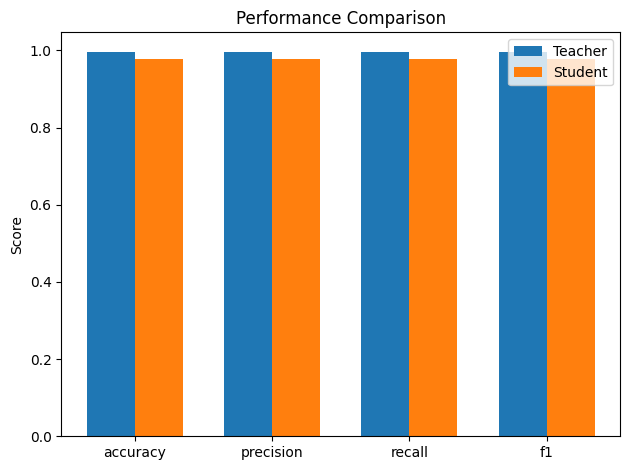

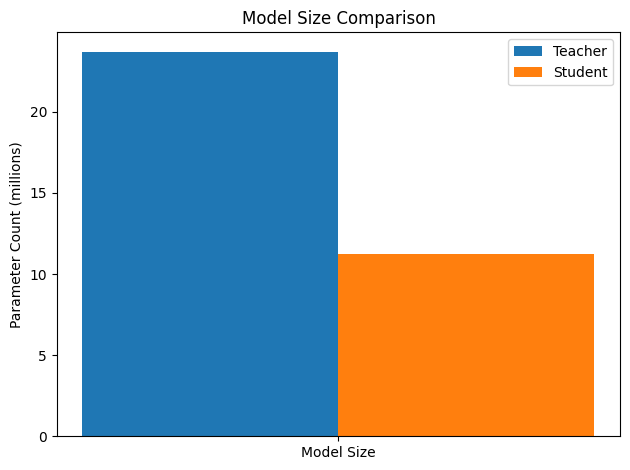

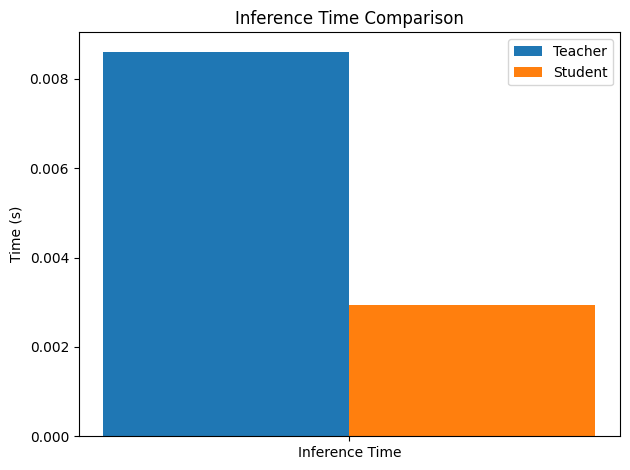

In [28]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, trainloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, trainloader)['metrics']
print(performance_metrics)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]

student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')

{'accuracy': (1.0, 1.0), 'precision': (1.0, 1.0), 'recall': (1.0, 1.0), 'f1': (1.0, 1.0)}


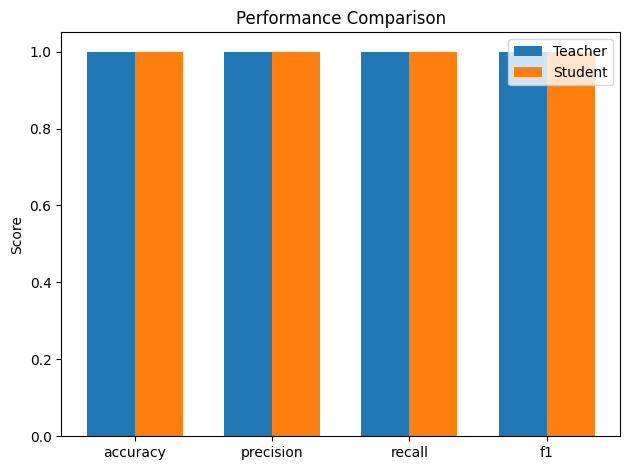

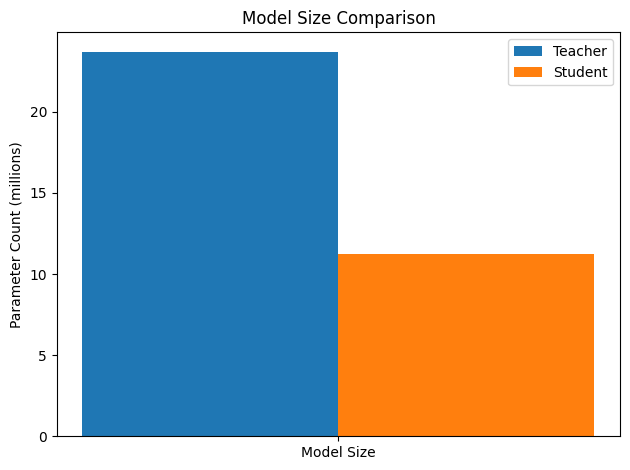

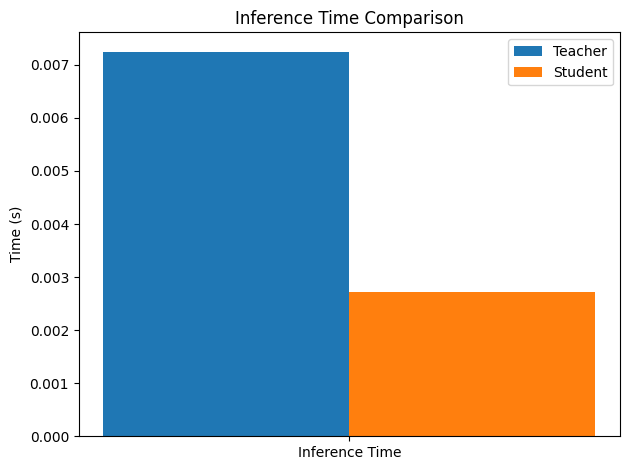

In [30]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)['metrics']
print(performance_metrics)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]

student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')